Importiamo le librerie necessarie.

In [1]:
from keras_vggface.vggface import VGGFace
from keras.models import Model
from keras.layers import Input, AveragePooling2D, Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.callbacks import CSVLogger
from keras import backend as K
from keras.constraints import Constraint
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd

Using TensorFlow backend.


Carichiamo il modello della **VGGFace** e settiamo la dimensione dell'immagine a 224X224. Il modello caricato è quello della vggface basato però su resnet50, come indicato dalla parola **model**.

In [2]:
input_tensor = Input(shape=(224, 224, 3))
base_model = VGGFace(model='resnet50', input_tensor=input_tensor, include_top=False)

Consideriamo tutti i layer della VGGFace. Per migliorare le prestazioni sono stati aggiunti cinque layer: AveragePooling, Flatten, Dense, Dropout settato a 0.5 e un ultimo layer Dense con numero di classi pari a 7. Inoltre abbiamo impostato il trainable di tutti i layer a False.

In [3]:
for layer in base_model.layers:
    layer.trainable=False

x = base_model.output
x = AveragePooling2D(pool_size=(7,7), padding='same')(x)
x = Flatten(name="flatten")(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(7, activation="softmax")(x)

updatedModel = Model(base_model.input, x)
updatedModel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____________________________________________________________________________________________

Successivamente carichiamo la cartella contente le immagini di Train e Validation. Attraverso il metodo **ImageDataGenerator** viene applicato un flip orizzontale a tali immagini.

In [4]:
train_folder = "../Train"
val_folder = "../Val"

train_datagen = ImageDataGenerator(horizontal_flip=True)
val_datagen = ImageDataGenerator(horizontal_flip=True)

Attraverso il metodo **flow_from_directory** creiamo i batch con le immagini preprocessate. Inizialmente abbiamo settato un batchsize di train pari a 512, successivamente modificato a 32 a causa di un errore dovuto ad un memory leak.

In [5]:
train_batchsize = 32
val_batchsize = 8
IMAGE_SIZE = 224

train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=train_batchsize,
        class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
        val_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=val_batchsize,
        class_mode="categorical",
        shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


Per evitare di avere una **val_acc** il cui valore rimane invariato per un numero elevato di epoche, utilizziamo il metodo **ReduceLROnPlateau** per decrementare il learning rate di 10 unità ogni 10 epoche. 

In [6]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1 , patience = 10)

csv_logger = CSVLogger('resnet_training.log', separator=',', append=False)
callbacks_list = [reduce_lr, csv_logger]

Settiamo un numero di epoche pari a 200 e un learning rate di 10^-4, come ottimizzatore utilizziamo l'**SGD** con un momentum settato a 0.9. E' importante settare questi iperparametri in quanto andranno ad influenzare il training del modello.

In [7]:
num_epochs = 200
learning_rate = 1e-4
sgd = SGD(lr=learning_rate, momentum = 0.9)
updatedModel.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['acc'])

Effettuiamo il training del modello attraverso il metodo **fit_generator** e successivamente salviamo il modello nella cartella saves.

In [9]:
history = updatedModel.fit_generator(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator,
    verbose=1,
    callbacks=callbacks_list
)

updatedModel.save('../saves/ResNet50.hdf5')

Epoch 1/200
898/898 [==============================] - 223s 248ms/step - loss: 2.2641 - acc: 0.2857 - val_loss: 2.0692 - val_acc: 0.4018s: 2
Epoch 2/200
898/898 [==============================] - 215s 240ms/step - loss: 1.6215 - acc: 0.3824 - val_loss: 1.8712 - val_acc: 0.4369
Epoch 3/200
898/898 [==============================] - 216s 240ms/step - loss: 1.5103 - acc: 0.4238 - val_loss: 1.6929 - val_acc: 0.4609
Epoch 4/200
898/898 [==============================] - 215s 240ms/step - loss: 1.4398 - acc: 0.4518 - val_loss: 1.9555 - val_acc: 0.4773
Epoch 5/200
898/898 [==============================] - 216s 240ms/step - loss: 1.3838 - acc: 0.4748 - val_loss: 1.9201 - val_acc: 0.4954
Epoch 6/200
898/898 [==============================] - 216s 240ms/step - loss: 1.3463 - acc: 0.4906 - val_loss: 2.0090 - val_acc: 0.4957
Epoch 7/200
898/898 [==============================] - 216s 240ms/step - loss: 1.3146 - acc: 0.5073 - val_loss: 2.0258 - val_acc: 0.5065
Epoch 8/200
898/898 [================

898/898 [==============================] - 215s 239ms/step - loss: 1.1621 - acc: 0.5707 - val_loss: 1.9360 - val_acc: 0.5233s
Epoch 118/200
898/898 [==============================] - 215s 240ms/step - loss: 1.1699 - acc: 0.5638 - val_loss: 2.1174 - val_acc: 0.5208
Epoch 119/200
898/898 [==============================] - 215s 239ms/step - loss: 1.1628 - acc: 0.5647 - val_loss: 1.9881 - val_acc: 0.5266s - loss: - ETA: 1s - loss: 1.1615 - acc:
Epoch 120/200
898/898 [==============================] - 215s 239ms/step - loss: 1.1625 - acc: 0.5640 - val_loss: 2.1363 - val_acc: 0.5277
Epoch 121/200
898/898 [==============================] - 215s 240ms/step - loss: 1.1642 - acc: 0.5663 - val_loss: 2.2400 - val_acc: 0.5272
Epoch 122/200
898/898 [==============================] - 215s 240ms/step - loss: 1.1606 - acc: 0.5659 - val_loss: 2.1182 - val_acc: 0.5280
Epoch 123/200
898/898 [==============================] - 215s 240ms/step - loss: 1.1673 - acc: 0.5651 - val_loss: 2.1099 - val_acc: 0.5283

# Plot


Effettuiamo il **plot** delle metriche del modello.

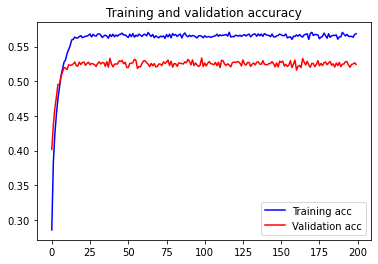

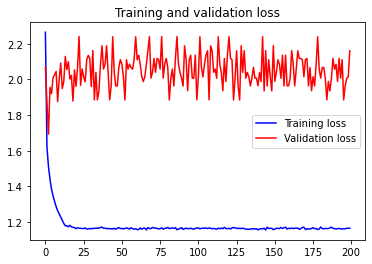

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Fase TEST

Importiamo le librerie necessarie

In [2]:
import random
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns

Nella funzione creata di seguito si procede con la costruzione della matrice di confusione. 

In [12]:
def show_confusion_matrix(validations, predictions, labels):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Una volta aver creato la matrice di confusione, procediamo con il caricamento delle immagini di test. Esse avranno dimensione 224X224, inoltre la dimensione di batchsize è stata impostata a 1.

In [13]:
test_folder = "../Test"
IMAGE_SIZE = 224
random.seed(3)
test_batchsize = 1

Carichiamo il modello addestrato.

In [14]:
model = load_model('../saves/ResNet50.hdf5')

Successivamente carichiamo la cartella contente le immagini di Train e Validation. Attraverso il metodo **flow_from_directory** creiamo i batch con le immagini preprocessate.

test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=test_batchsize,
        class_mode='categorical',
        shuffle=False)

Andiamo a leggere le classi assegnate agli esempi di test e il corrispettivo indice numerico.

In [21]:
ground_truth = test_generator.classes
label2index = test_generator.class_indices
idx2label = dict((v, k) for k, v in label2index.items())

Attraverso il mettodo **predict_generator** effettuiamo la classificazione delle immagini. 

In [22]:
predictions = model.predict_generator(test_generator,
                      steps=test_generator.samples / test_generator.batch_size,
                      verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

3589/3589 [==============================] - 76s 21ms/step


Una volta completata la classificazione calcoliamo gli errori effettuati dal modello, la matrice di confusione e le metriche prestazionali.

No of errors = 1617/3589


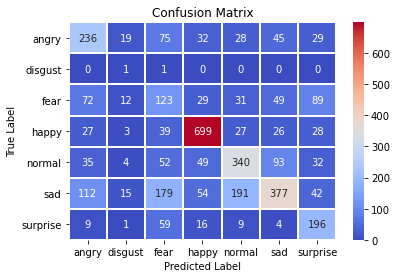

              precision    recall  f1-score   support

           0       0.48      0.51      0.49       464
           1       0.02      0.50      0.04         2
           2       0.23      0.30      0.26       405
           3       0.80      0.82      0.81       849
           4       0.54      0.56      0.55       605
           5       0.63      0.39      0.48       970
           6       0.47      0.67      0.55       294

    accuracy                           0.55      3589
   macro avg       0.45      0.54      0.46      3589
weighted avg       0.58      0.55      0.55      3589



In [23]:
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors), test_generator.samples))
labels = ["angry", "disgust", "fear", "happy", "normal", "sad", "surprise"]
show_confusion_matrix(predicted_classes, ground_truth, labels)
print(classification_report(predicted_classes, ground_truth))

# Fase SPARSE

Importiamo le librerie necessarie

In [3]:
from keras.layers import deserialize as layer_from_config
from keras.models import model_from_config
from keras.models import Model

from keras.layers import Input, AveragePooling2D, Dense, Dropout, Flatten

Carichiamo il modello addestrato, il modello della **VGGFace** basato su resnet50 e settiamo la dimensione dell'immagine a 224.

In [19]:
model =  load_model('../saves/ResNet50.hdf5')
input_tensor = Input(shape=(224, 224, 3))
sparse_model = VGGFace(model='resnet50', input_tensor=input_tensor, include_top=False)

Andiamo a calcolare le posizioni del modello in cui sono presenti dei layer convoluzionali. Ciò sarà utile perchè andremo ad inserire nelle medesime un kernel constraint.

In [4]:
layers = sparse_model.layers
pos = []
val = 0
for layer in layers:
    string = str(layer)
    if 'Conv2D' in string:
        pos.append(val)
    val = val + 1
print(pos)

config = sparse_model.get_config()

[1, 5, 8, 11, 12, 17, 20, 23, 27, 30, 33, 37, 40, 43, 44, 49, 52, 55, 59, 62, 65, 69, 72, 75, 79, 82, 85, 86, 91, 94, 97, 101, 104, 107, 111, 114, 117, 121, 124, 127, 131, 134, 137, 141, 144, 147, 148, 153, 156, 159, 163, 166, 169]


Andiamo a definire la clsse **Sparse** con i metodi **_init_**, **_call_** e **get_config**.

In [5]:
class Sparse(Constraint):
    def __init__(self, mask):
        self.mask = K.cast_to_floatx(mask)
    
    def __call__(self,x):
        return self.mask * x
    
    def get_config(self):
        return {'mask': self.mask}

Nella funzione creata di seguito andiamo a calcolare, per ogni layer del modello, una percentuale del peso e se quest'ultima dovesse essere vicina a 0, viene settato a 0 il valore di quel peso. Così facendo restituiamo una maschera con la percentuale dei pesi il più possibile vicina a 0, in modo tale, da incrementare l'accuratezza del modello durante la fase di training. Questo è stato possibile grazie ad una sparsity_mask, nella quale è stato impostato uno sparsity_rate del 60%. 

In [6]:
def create_sparsity_masks(model,sparsity):
    weights_list = model.get_weights()
    masks = []
    for weights in weights_list:
        #We can ignore biases
        if len(weights.shape) > 1:
            weights_abs = np.abs(weights)
            masks.append((weights_abs>np.percentile(weights_abs,sparsity))*1.)
    return masks

Richiamiamo la funzione **create_sparsity_masks** per ottenera una maschera con pesi vicini a 0.

In [7]:
masks = create_sparsity_masks(model,60)

Per migliorare le prestazioni sono stati aggiunti al modello cinque layer: AveragePooling, Flatten, Dense, Dropout settato a 0.5 e un ultimo layer Dense con numero di classi pari a 7.

In [8]:
x = sparse_model.output
x = AveragePooling2D(pool_size=(7, 7), padding='same')(x)
x = Flatten(name="flatten")(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(7, activation="softmax")(x)

sparse_model= Model(sparse_model.input, x)

Consideriamo i layer della VGGFace, settando il trainable dei primi 174 layer a False e aggiungendo un **kernel_constraint** ai layer convoluzionali.

In [9]:
layers = sparse_model.layers
layers = layers[0:173]
for layer in layers:
    layer.trainable=False
    
count = 0
for n in pos:
    layers[n].kernel_constraint = Sparse(masks[count])
    count = count + 1

sparse_model.set_weights(model.get_weights())

sparse_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____________________________________________________________________________________________

Successivamente carichiamo la cartella contente le immagini di Train e Validation. Attraverso il metodo **ImageDataGenerator** viene applicato un flip orizzontale a tali immagini.

In [10]:
train_folder = "../Train"
val_folder = "../Val"

train_datagen = ImageDataGenerator(horizontal_flip=True)
val_datagen = ImageDataGenerator(horizontal_flip=True)

Attraverso il metodo **flow_from_directory** creiamo i batch con le immagini preprocessate. Inizialmente abbiamo settato un batchsize di train pari a 512, successivamente modificato a 32 a causa di un errore dovuto ad un memory leak.

In [11]:
train_batchsize = 32
val_batchsize = 8
IMAGE_SIZE = 224
train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=train_batchsize,
        class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
        val_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=val_batchsize,
        class_mode="categorical",
        shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


Per evitare di avere una **val_acc** il cui valore rimane invariato per un numero elevato di epoche, utilizziamo il metodo **ReduceLROnPlateau** per decrementare il learning rate di 10 unità ogni 10 epoche. Ci avvaliamo della funzione **CSVLogger** per salvare un file .log contente tutte le informazioni dell'addestramento.

In [12]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1 , patience = 10)

csv_logger = CSVLogger('resnet_sparse_training.log', separator=',', append=False)
callbacks_list = [reduce_lr, csv_logger]

Andiamo a leggere i valori dei learning rate dal file **.log** utilizzando il metodo **read_csv** e li inseriamo nella variabile **lr**.

In [14]:
log = pd.read_csv('../log/resnet_training.log')
dim = len(log['lr'])
lr = log['lr']

Settiamo un numero di epoche pari a 50 e un learning rate uguale all'ultimo valore letto dal file .log, come ottimizzatore utilizziamo l'**SGD** con un momentum settato a 0.9. E' importante settare questi iperparametri in quanto andranno ad influenzare il training del modello.

In [15]:
num_epochs = 50
learning_rate = lr[dim-1]
sgd = SGD(lr=learning_rate, momentum = 0.9)
sparse_model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['acc'])

Effettuiamo il training del modello attraverso il metodo **fit_generator** e successivamente salviamo il modello nella cartella saves.

In [16]:
history = sparse_model.fit_generator(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator,
    verbose=1,
    callbacks=callbacks_list
)
sparse_model.save('../saves/resnet_sparse_model.hdf5')

Epoch 1/50
898/898 [==============================] - 225s 250ms/step - loss: 1.1645 - acc: 0.5628 - val_loss: 2.0578 - val_acc: 0.5263
Epoch 2/50
898/898 [==============================] - 221s 246ms/step - loss: 1.1652 - acc: 0.5676 - val_loss: 2.2400 - val_acc: 0.5263
Epoch 3/50
898/898 [==============================] - 220s 245ms/step - loss: 1.1594 - acc: 0.5687 - val_loss: 2.0136 - val_acc: 0.5249
Epoch 4/50
898/898 [==============================] - 227s 252ms/step - loss: 1.1704 - acc: 0.5654 - val_loss: 2.0569 - val_acc: 0.5255
Epoch 5/50
898/898 [==============================] - 217s 242ms/step - loss: 1.1663 - acc: 0.5629 - val_loss: 2.1892 - val_acc: 0.5255
Epoch 6/50
898/898 [==============================] - 218s 242ms/step - loss: 1.1618 - acc: 0.5668 - val_loss: 2.0578 - val_acc: 0.5263
Epoch 7/50
898/898 [==============================] - 217s 242ms/step - loss: 1.1613 - acc: 0.5682 - val_loss: 2.1892 - val_acc: 0.5280
Epoch 8/50
898/898 [============================

# Plot fase Sparse

Effettuiamo il **plot** delle metriche del modello.

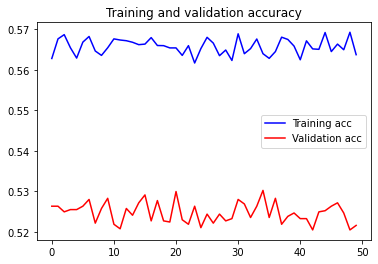

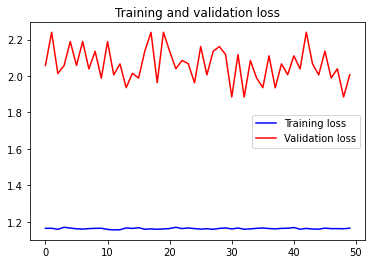

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Test fase Sparse

Importiamo le librerie necessarie.

In [9]:
import random
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns
import keras

Nella funzione creata di seguito si procede con la costruzione della matrice di confusione.

In [5]:
def show_confusion_matrix(validations, predictions, labels):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Una volta aver creato la matrice di confusione, procediamo con il caricamento delle immagini di test. Esse avranno dimensione 224X224, inoltre la dimensione di batchsize è stata impostata a 1.

In [6]:
test_folder = "../Test"
IMAGE_SIZE = 224
random.seed(3)
test_batchsize = 1

Andiamo a definire la clsse **Sparse** con i metodi **_init_**, **_call_** e **get_config**.

In [13]:
class Sparse(Constraint):
    def __init__(self, mask):
        self.mask = K.cast_to_floatx(mask)
    
    def __call__(self,x):
        return self.mask * x
    
    def get_config(self):
        return {'mask': self.mask}

Carichiamo il modello addestrato.

In [15]:
model = load_model('../saves/resnet_sparse_model.hdf5', custom_objects={'Sparse': Sparse})

Successivamente carichiamo la cartella contente le immagini di Train e Validation. Attraverso il metodo **flow_from_directory** creiamo i batch con le immagini preprocessate.

In [17]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=test_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 3589 images belonging to 7 classes.


Andiamo a leggere le classi assegnate agli esempi di test e il corrispettivo indice numerico.

In [18]:
ground_truth = test_generator.classes
label2index = test_generator.class_indices
idx2label = dict((v, k) for k, v in label2index.items())

Attraverso il mettodo **predict_generator** effettuiamo la classificazione delle immagini. 

In [19]:
predictions = model.predict_generator(test_generator,
                      steps=test_generator.samples / test_generator.batch_size,
                      verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

3589/3589 [==============================] - 138s 38ms/step


Una volta completata la classificazione calcoliamo gli errori effettuati dal modello, la matrice di confusione e le metriche prestazionali.

No of errors = 1617/3589


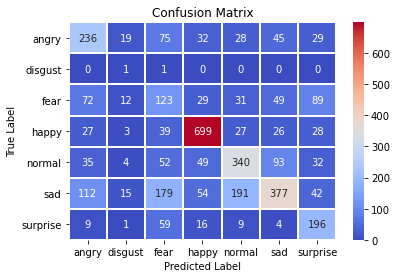

              precision    recall  f1-score   support

           0       0.48      0.51      0.49       464
           1       0.02      0.50      0.04         2
           2       0.23      0.30      0.26       405
           3       0.80      0.82      0.81       849
           4       0.54      0.56      0.55       605
           5       0.63      0.39      0.48       970
           6       0.47      0.67      0.55       294

    accuracy                           0.55      3589
   macro avg       0.45      0.54      0.46      3589
weighted avg       0.58      0.55      0.55      3589



In [20]:
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors), test_generator.samples))
labels = ["angry", "disgust", "fear", "happy", "normal", "sad", "surprise"]
show_confusion_matrix(predicted_classes, ground_truth, labels)
print(classification_report(predicted_classes, ground_truth))

# Seconda fase Dense

Andiamo a definire la clsse **Sparse** con i metodi **_init_**, **_call_** e **get_config**.

In [21]:
class Sparse(Constraint):
    def __init__(self, mask):
        self.mask = K.cast_to_floatx(mask)
    
    def __call__(self,x):
        return self.mask * x
    
    def get_config(self):
        return {'mask': self.mask}

Carichiamo il modello addestrato, il modello della **VGGFace** basato su resnet50 e settiamo la dimensione dell'immagine a 224.

In [22]:
sparse_model = load_model('../saves/resnet_sparse_model.hdf5', custom_objects={'Sparse': Sparse})
input_tensor = Input(shape=(224, 224, 3))
base_model = VGGFace(model='resnet50', input_tensor=input_tensor, include_top=False)

Consideriamo tutti i layer della VGGFace. Per migliorare le prestazioni sono stati aggiunti cinque layer: AveragePooling, Flatten, Dense, Dropout settato a 0.5 e un ultimo layer Dense con numero di classi pari a 7. Inoltre abbiamo impostato il trainable di tutti i layer a False.

In [23]:
for layer in base_model.layers:
    layer.trainable=False

x = base_model.output
x = AveragePooling2D(pool_size=(7,7), padding='same')(x)
x = Flatten(name="flatten")(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(7, activation="softmax")(x)

updatedModel = Model(base_model.input, x)
updatedModel.set_weights(sparse_model.get_weights())
updatedModel.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____________________________________________________________________________________________

Successivamente carichiamo la cartella contente le immagini di Train e Validation. Attraverso il metodo **ImageDataGenerator** vengono applicate delle funzioni di pre-processing e un flip orizzontale a tali immagini.

In [24]:
train_folder = "../Train"
val_folder = "../Val"

train_datagen = ImageDataGenerator(horizontal_flip=True)
val_datagen = ImageDataGenerator(horizontal_flip=True)

Attraverso il metodo **flow_from_directory** creiamo i batch con le immagini preprocessate. Inizialmente abbiamo settato un batchsize di train pari a 512, successivamente modificato a 32 a causa di un errore dovuto ad un memory leak.

In [25]:
train_batchsize = 32
val_batchsize = 8

train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=train_batchsize,
        class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
        val_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=val_batchsize,
        class_mode="categorical",
        shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


Per evitare di avere una **val_acc** il cui valore rimane invariato per un numero elevato di epoche, utilizziamo il metodo **ReduceLROnPlateau** per decrementare il learning rate di 10 unità ogni 10 epoche. Ci avvaliamo della funzione **CSVLogger** per salvare un file .log contente tutte le informazioni dell'addestramento.

In [26]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1 , patience = 10)

csv_logger = CSVLogger('redense_resnet_training.log', separator=',', append=False)
callbacks_list = [reduce_lr, csv_logger]

Andiamo a leggere i valori dei learning rate dal file **.log** utilizzando il metodo **read_csv** e li inseriamo nella variabile **lr**.

In [27]:
log = pd.read_csv('../notebook/resnet_sparse_training.log')
dim = len(log['lr'])
lr = log['lr']

Settiamo un numero di epoche pari a 50 e un learning rate uguale all'ultimo valore letto dal file .log, come ottimizzatore utilizziamo l'**SGD** con un momentum settato a 0.9. E' importante settare questi iperparametri in quanto andranno ad influenzare il training del modello.

In [28]:
num_epochs = 50
learning_rate = lr[dim-1]
sgd = SGD(lr=learning_rate, momentum = 0.9)
updatedModel.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['acc'])

Effettuiamo il training del modello attraverso il metodo **fit_generator** e successivamente salviamo il modello nella cartella saves.

In [29]:
history = updatedModel.fit_generator(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator,
    verbose=1,
    callbacks=callbacks_list
)

updatedModel.save('../saves/redense_ResNet50.hdf5')

Epoch 1/50
898/898 [==============================] - 226s 252ms/step - loss: 1.1716 - acc: 0.5652 - val_loss: 2.1606 - val_acc: 0.5244
Epoch 2/50
898/898 [==============================] - 220s 245ms/step - loss: 1.1584 - acc: 0.5710 - val_loss: 2.0674 - val_acc: 0.5241
Epoch 3/50
898/898 [==============================] - 220s 245ms/step - loss: 1.1644 - acc: 0.5623 - val_loss: 2.0847 - val_acc: 0.5249
Epoch 4/50
898/898 [==============================] - 221s 246ms/step - loss: 1.1644 - acc: 0.5658 - val_loss: 2.0855 - val_acc: 0.5219
Epoch 5/50
898/898 [==============================] - 221s 246ms/step - loss: 1.1635 - acc: 0.5646 - val_loss: 2.0674 - val_acc: 0.5230
Epoch 6/50
898/898 [==============================] - 216s 241ms/step - loss: 1.1598 - acc: 0.5668 - val_loss: 2.1615 - val_acc: 0.5241
Epoch 7/50
898/898 [==============================] - 216s 240ms/step - loss: 1.1607 - acc: 0.5682 - val_loss: 1.9629 - val_acc: 0.5249
Epoch 8/50
898/898 [============================

# Plot seconda fase Dense

Effettuiamo il **plot** delle metriche del modello.

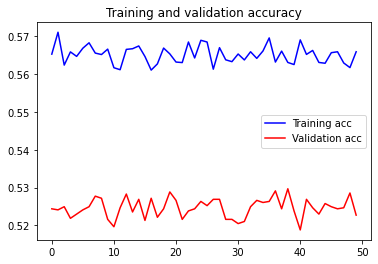

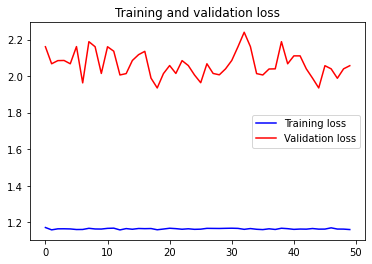

In [30]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Test seconda fase Dense

Importiamo le librerie necessarie

In [31]:
import random
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns

Nella funzione creata di seguito si procede con la costruzione della matrice di confusione. 

In [32]:
def show_confusion_matrix(validations, predictions, labels):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Una volta aver creato la matrice di confusione, procediamo con il caricamento delle immagini di test. Esse avranno dimensione 224X224, inoltre la dimensione di batchsize è stata impostata a 1.

In [33]:
test_folder = "../Test"
IMAGE_SIZE = 224
random.seed(3)
test_batchsize = 1

Carichiamo il modello addestrato.

In [34]:
model = load_model('../saves/redense_ResNet50.hdf5')

Successivamente carichiamo la cartella contente le immagini di Train e Validation. Attraverso il metodo **flow_from_directory** creiamo i batch con le immagini preprocessate.

In [35]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=test_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 3589 images belonging to 7 classes.


Andiamo a leggere le classi assegnate agli esempi di test e il corrispettivo indice numerico.

In [36]:
ground_truth = test_generator.classes
label2index = test_generator.class_indices
idx2label = dict((v, k) for k, v in label2index.items())

Attraverso il mettodo **predict_generator** effettuiamo la classificazione delle immagini. 

In [37]:
predictions = model.predict_generator(test_generator,
                      steps=test_generator.samples / test_generator.batch_size,
                      verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

3589/3589 [==============================] - 72s 20ms/step


Una volta completata la classificazione calcoliamo gli errori effettuati dal modello, la matrice di confusione e le metriche prestazionali.

No of errors = 1617/3589


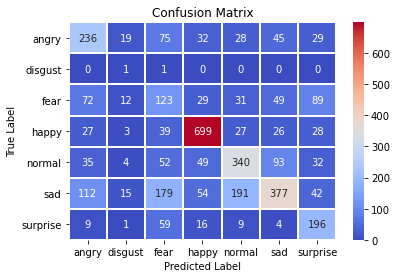

              precision    recall  f1-score   support

           0       0.48      0.51      0.49       464
           1       0.02      0.50      0.04         2
           2       0.23      0.30      0.26       405
           3       0.80      0.82      0.81       849
           4       0.54      0.56      0.55       605
           5       0.63      0.39      0.48       970
           6       0.47      0.67      0.55       294

    accuracy                           0.55      3589
   macro avg       0.45      0.54      0.46      3589
weighted avg       0.58      0.55      0.55      3589



In [38]:
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors), test_generator.samples))
labels = ["angry", "disgust", "fear", "happy", "normal", "sad", "surprise"]
show_confusion_matrix(predicted_classes, ground_truth, labels)
print(classification_report(predicted_classes, ground_truth))

# Seconda fase Sparse

Carichiamo il modello addestrato, il modello della **VGGFace** basato su resnet50 e settiamo la dimensione dell'immagine a 224.

In [3]:
model =  load_model('../saves/redense_ResNet50.hdf5')
input_tensor = Input(shape=(224, 224, 3))
sparse_model = VGGFace(model='resnet50', input_tensor=input_tensor, include_top=False)

Andiamo a calcolare le posizioni del modello in cui sono presenti dei layer convoluzionali. Ciò sarà utile perchè andremo ad inserire nelle medesime un kernel constraint.

In [4]:
layers = sparse_model.layers
pos = []
val = 0
for layer in layers:
    string = str(layer)
    if 'Conv2D' in string:
        pos.append(val)
    val = val + 1
print(pos)

config = sparse_model.get_config()

[1, 5, 8, 11, 12, 17, 20, 23, 27, 30, 33, 37, 40, 43, 44, 49, 52, 55, 59, 62, 65, 69, 72, 75, 79, 82, 85, 86, 91, 94, 97, 101, 104, 107, 111, 114, 117, 121, 124, 127, 131, 134, 137, 141, 144, 147, 148, 153, 156, 159, 163, 166, 169]


Andiamo a definire la clsse **Sparse** con i metodi **_init_**, **_call_** e **get_config**.

In [5]:
class Sparse(Constraint):
    def __init__(self, mask):
        self.mask = K.cast_to_floatx(mask)
    
    def __call__(self,x):
        return self.mask * x
    
    def get_config(self):
        return {'mask': self.mask}

Nella funzione creata di seguito andiamo a calcolare, per ogni layer del modello, una percentuale del peso e se quest'ultima dovesse essere vicina a 0, viene settato a 0 il valore di quel peso. Così facendo restituiamo una maschera con la percentuale dei pesi il più possibile vicina a 0, in modo tale, da incrementare l'accuratezza del modello durante la fase di training. Questo è stato possibile grazie ad una sparsity_mask, nella quale è stato impostato uno sparsity_rate del 60%. 

In [6]:
def create_sparsity_masks(model,sparsity):
    weights_list = model.get_weights()
    masks = []
    for weights in weights_list:
        #We can ignore biases
        if len(weights.shape) > 1:
            weights_abs = np.abs(weights)
            masks.append((weights_abs>np.percentile(weights_abs,sparsity))*1.)
    return masks

Richiamiamo la funzione **create_sparsity_masks** per ottenera una maschera con pesi vicini a 0.

In [7]:
masks = create_sparsity_masks(model,60)

Per migliorare le prestazioni sono stati aggiunti cinque layer: AveragePooling, Flatten, Dense, Dropout settato a 0.5 e un ultimo layer Dense con numero di classi pari a 7.

In [8]:
x = sparse_model.output
x = AveragePooling2D(pool_size=(7, 7), padding='same')(x)
x = Flatten(name="flatten")(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(7, activation="softmax")(x)

sparse_model= Model(sparse_model.input, x)

Consideriamo i layer della VGGFace, settando il trainable dei primi 174 layer a False e aggiungendo un **kernel_constraint** ai layer convoluzionali.

In [9]:
layers = sparse_model.layers
layers = layers[0:173]
for layer in layers:
    layer.trainable=False
    
count = 0
for n in pos:
    layers[n].kernel_constraint = Sparse(masks[count])
    count = count + 1

sparse_model.set_weights(model.get_weights())

sparse_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____________________________________________________________________________________________

Successivamente carichiamo la cartella contente le immagini di Train e Validation. Attraverso il metodo **ImageDataGenerator** vengono applicate delle funzioni di pre-processing e un flip orizzontale a tali immagini.

In [10]:
train_folder = "../Train"
val_folder = "../Val"

train_datagen = ImageDataGenerator(horizontal_flip=True)
val_datagen = ImageDataGenerator(horizontal_flip=True)

Attraverso il metodo **flow_from_directory** creiamo i batch con le immagini preprocessate. Inizialmente abbiamo settato un batchsize di train pari a 512, successivamente modificato a 32 a causa di un errore dovuto ad un memory leak.

In [11]:
train_batchsize = 32
val_batchsize = 8
IMAGE_SIZE = 224
train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=train_batchsize,
        class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
        val_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=val_batchsize,
        class_mode="categorical",
        shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


Attraverso il metodo **flow_from_directory** creiamo i batch con le immagini preprocessate. Inizialmente abbiamo settato un batchsize di train pari a 512, successivamente modificato a 32 a causa di un errore dovuto ad un memory leak.

In [12]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1 , patience = 10)

csv_logger = CSVLogger('resnet_sparse2_training.log', separator=',', append=False)
callbacks_list = [reduce_lr, csv_logger]

Andiamo a leggere i valori dei learning rate dal file **.log** utilizzando il metodo **read_csv** e li inseriamo nella variabile **lr**.

In [13]:
log = pd.read_csv('../notebook/redense_resnet_training.log')
dim = len(log['lr'])
lr = log['lr']

Settiamo un numero di epoche pari a 50 e un learning rate uguale all'ultimo valore letto dal file .log, come ottimizzatore utilizziamo l'**SGD** con un momentum settato a 0.9. E' importante settare questi iperparametri in quanto andranno ad influenzare il training del modello.

In [14]:
num_epochs = 50
learning_rate = lr[dim-1]
sgd = SGD(lr=learning_rate, momentum = 0.9)
sparse_model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['acc'])

Effettuiamo il training del modello attraverso il metodo **fit_generator** e successivamente salviamo il modello nella cartella saves.

In [15]:
history = sparse_model.fit_generator(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator,
    verbose=1,
    callbacks=callbacks_list
)
sparse_model.save('../saves/resnet_sparse2_model.hdf5')

Epoch 1/50
898/898 [==============================] - 222s 248ms/step - loss: 1.1581 - acc: 0.5668 - val_loss: 1.9629 - val_acc: 0.5216
Epoch 2/50
898/898 [==============================] - 216s 241ms/step - loss: 1.1625 - acc: 0.5676 - val_loss: 1.8852 - val_acc: 0.5222
Epoch 3/50
898/898 [==============================] - 216s 241ms/step - loss: 1.1601 - acc: 0.5648 - val_loss: 2.1182 - val_acc: 0.5263
Epoch 4/50
898/898 [==============================] - 216s 241ms/step - loss: 1.1563 - acc: 0.5695 - val_loss: 2.0062 - val_acc: 0.5194
Epoch 5/50
898/898 [==============================] - 216s 241ms/step - loss: 1.1592 - acc: 0.5692 - val_loss: 1.9629 - val_acc: 0.5241
Epoch 6/50
898/898 [==============================] - 216s 241ms/step - loss: 1.1634 - acc: 0.5656 - val_loss: 1.9629 - val_acc: 0.5263
Epoch 7/50
898/898 [==============================] - 216s 241ms/step - loss: 1.1591 - acc: 0.5647 - val_loss: 1.9360 - val_acc: 0.5283
Epoch 8/50
898/898 [============================

# Plot seconda fase Sparse

Effettuiamo il **plot** delle metriche del modello.

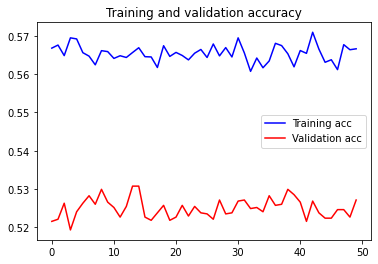

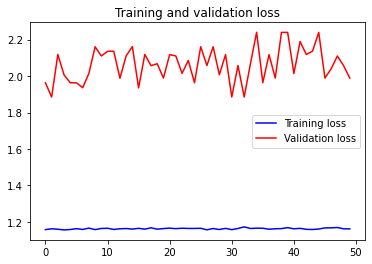

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Test seconda fase Sparse

importiamo le librerie del modello

In [17]:
import random
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns

Nella funzione creata di seguito si procede con la costruzione della matrice di confusione.

In [18]:
def show_confusion_matrix(validations, predictions, labels):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Una volta aver creato la matrice di confusione, procediamo con il caricamento delle immagini di test. Esse avranno dimensione 224X224, inoltre la dimensione di batchsize è stata impostata a 1.

In [19]:
test_folder = "../Test"
IMAGE_SIZE = 224
random.seed(3)
test_batchsize = 1

Carichiamo il modello addestrato.

In [21]:
model = load_model('../saves/resnet_sparse2_model.hdf5', custom_objects={'Sparse': Sparse})

Successivamente carichiamo la cartella contente le immagini di Train e Validation. Attraverso il metodo **flow_from_directory** creiamo i batch con le immagini preprocessate.

In [22]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=test_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 3589 images belonging to 7 classes.


Andiamo a leggere le classi assegnate agli esempi di test e il corrispettivo indice numerico.

In [23]:
ground_truth = test_generator.classes
label2index = test_generator.class_indices
idx2label = dict((v, k) for k, v in label2index.items())

Attraverso il mettodo **predict_generator** effettuiamo la classificazione delle immagini.

In [24]:
predictions = model.predict_generator(test_generator,
                      steps=test_generator.samples / test_generator.batch_size,
                      verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

3589/3589 [==============================] - 72s 20ms/step


Una volta completata la classificazione calcoliamo gli errori effettuati dal modello, la matrice di confusione e le metriche prestazionali.

No of errors = 1617/3589


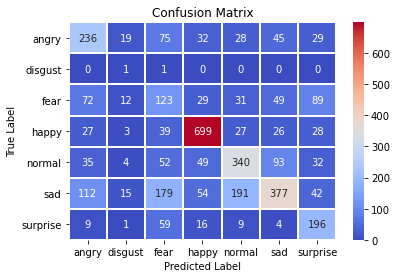

              precision    recall  f1-score   support

           0       0.48      0.51      0.49       464
           1       0.02      0.50      0.04         2
           2       0.23      0.30      0.26       405
           3       0.80      0.82      0.81       849
           4       0.54      0.56      0.55       605
           5       0.63      0.39      0.48       970
           6       0.47      0.67      0.55       294

    accuracy                           0.55      3589
   macro avg       0.45      0.54      0.46      3589
weighted avg       0.58      0.55      0.55      3589



In [25]:
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors), test_generator.samples))
labels = ["angry", "disgust", "fear", "happy", "normal", "sad", "surprise"]
show_confusion_matrix(predicted_classes, ground_truth, labels)
print(classification_report(predicted_classes, ground_truth))

# Terza fase Dense

Carichiamo il modello addestrato, il modello della **VGGFace** basato su resnet50 e settiamo la dimensione dell'immagine a 224.

In [27]:
sparse_model = load_model('../saves/resnet_sparse_model.hdf5', custom_objects={'Sparse': Sparse})
input_tensor = Input(shape=(224, 224, 3))
base_model = VGGFace(model='resnet50', input_tensor=input_tensor, include_top=False)

Consideriamo tutti i layer della VGGFace. Per migliorare le prestazioni sono stati aggiunti cinque layer: AveragePooling, Flatten, Dense, Dropout settato a 0.5 e un ultimo layer Dense con numero di classi pari a 7. Inoltre abbiamo impostato il trainable di tutti i layer a False.

In [28]:
for layer in base_model.layers:
    layer.trainable=False

x = base_model.output
x = AveragePooling2D(pool_size=(7,7), padding='same')(x)
x = Flatten(name="flatten")(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(7, activation="softmax")(x)

updatedModel = Model(base_model.input, x)
updatedModel.set_weights(sparse_model.get_weights())
updatedModel.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_2[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____________________________________________________________________________________________

Successivamente carichiamo la cartella contente le immagini di Train e Validation. Attraverso il metodo **ImageDataGenerator** viene applicato un flip orizzontale a tali immagini.

In [29]:
train_folder = "../Train"
val_folder = "../Val"

train_datagen = ImageDataGenerator(horizontal_flip=True)
val_datagen = ImageDataGenerator(horizontal_flip=True)

Attraverso il metodo **flow_from_directory** creiamo i batch con le immagini preprocessate. Inizialmente abbiamo settato un batchsize di train pari a 512, successivamente modificato a 32 a causa di un errore dovuto ad un memory leak.

In [30]:
train_batchsize = 32
val_batchsize = 8

train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=train_batchsize,
        class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
        val_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=val_batchsize,
        class_mode="categorical",
        shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


Per evitare di avere una **val_acc** il cui valore rimane invariato per un numero elevato di epoche, utilizziamo il metodo **ReduceLROnPlateau** per decrementare il learning rate di 10 unità ogni 10 epoche. Ci avvaliamo della funzione **CSVLogger** per salvare un file .log contente tutte le informazioni dell'addestramento.

In [31]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1 , patience = 10)

csv_logger = CSVLogger('dense3_resnet_training.log', separator=',', append=False)
callbacks_list = [reduce_lr, csv_logger]

Andiamo a leggere i valori dei learning rate dal file **.log** utilizzando il metodo **read_csv** e li inseriamo nella variabile **lr**.

In [32]:
log = pd.read_csv('../notebook/resnet_sparse2_training.log')
dim = len(log['lr'])
lr = log['lr']

Settiamo un numero di epoche pari a 50 e un learning rate uguale all'ultimo valore letto dal file .log, come ottimizzatore utilizziamo l'**SGD** con un momentum settato a 0.9. E' importante settare questi iperparametri in quanto andranno ad influenzare il training del modello.

In [33]:
num_epochs = 50
learning_rate = lr[dim-1]
sgd = SGD(lr=learning_rate, momentum = 0.9)
updatedModel.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['acc'])

Effettuiamo il training del modello attraverso il metodo **fit_generator** e successivamente salviamo il modello nella cartella saves.

In [7]:
history = updatedModel.fit_generator(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator,
    verbose=1,
    callbacks=callbacks_list
)

updatedModel.save('../saves/dense3_ResNet50.hdf5')

NameError: name 'updatedModel' is not defined

# Plot terza fase Dense

Effettuiamo il **plot** delle metriche del modello.

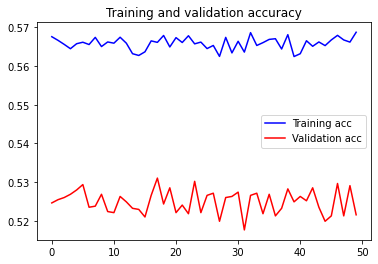

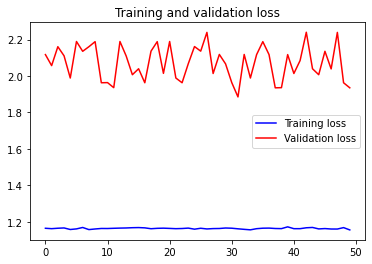

In [35]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Test terza Dense

Importiamo le librerie necessarie.

In [36]:
import random
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns

Nella funzione creata di seguito si procede con la costruzione della matrice di confusione.

In [37]:
def show_confusion_matrix(validations, predictions, labels):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Una volta aver creato la matrice di confusione, procediamo con il caricamento delle immagini di test. Esse avranno dimensione 224X224, inoltre la dimensione di batchsize è stata impostata a 1.

In [38]:
test_folder = "../Test"
IMAGE_SIZE = 224
random.seed(3)
test_batchsize = 1

Carichiamo il modello addestrato.

In [39]:
model = load_model('../saves/dense3_ResNet50.hdf5')

Successivamente carichiamo la cartella contente le immagini di Train e Validation. Attraverso il metodo **flow_from_directory** creiamo i batch con le immagini preprocessate.

In [40]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=test_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 3589 images belonging to 7 classes.


Andiamo a leggere le classi assegnate agli esempi di test e il corrispettivo indice numerico.

In [41]:
ground_truth = test_generator.classes
label2index = test_generator.class_indices
idx2label = dict((v, k) for k, v in label2index.items())

Attraverso il mettodo **predict_generator** effettuiamo la classificazione delle immagini.

In [42]:
predictions = model.predict_generator(test_generator,
                      steps=test_generator.samples / test_generator.batch_size,
                      verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

3589/3589 [==============================] - 73s 20ms/step


Una volta completata la classificazione calcoliamo gli errori effettuati dal modello, la matrice di confusione e le metriche prestazionali.

No of errors = 1617/3589


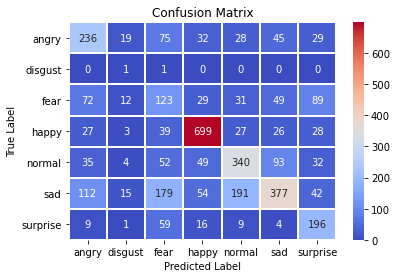

              precision    recall  f1-score   support

           0       0.48      0.51      0.49       464
           1       0.02      0.50      0.04         2
           2       0.23      0.30      0.26       405
           3       0.80      0.82      0.81       849
           4       0.54      0.56      0.55       605
           5       0.63      0.39      0.48       970
           6       0.47      0.67      0.55       294

    accuracy                           0.55      3589
   macro avg       0.45      0.54      0.46      3589
weighted avg       0.58      0.55      0.55      3589



In [43]:
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors), test_generator.samples))
labels = ["angry", "disgust", "fear", "happy", "normal", "sad", "surprise"]
show_confusion_matrix(predicted_classes, ground_truth, labels)
print(classification_report(predicted_classes, ground_truth))